## Long Short-Term Memory (LSTM)

Predicting sales on time-series data with the Recurrent Neural Network LSTM model

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('/content/Alcohol_Sales.csv',index_col=0,parse_dates=True)

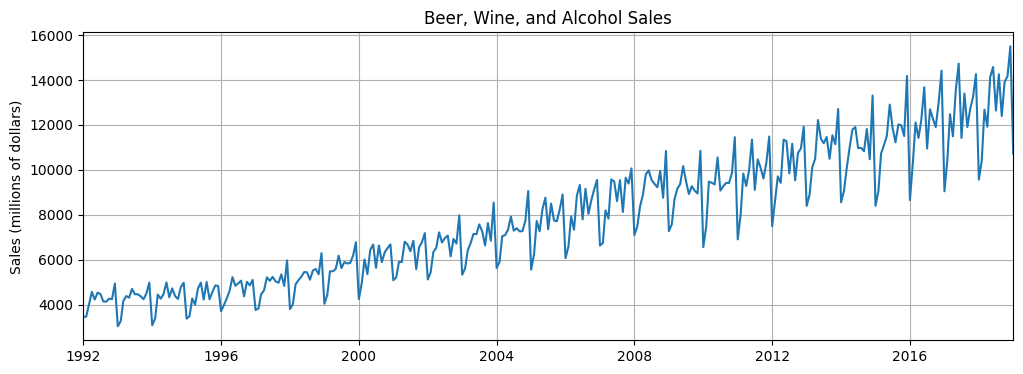

In [3]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

In [4]:
y = df['S4248SM144NCEN'].values.astype(float)

In [5]:
y[:10]

array([3459., 3458., 4002., 4564., 4221., 4529., 4466., 4137., 4126.,
       4259.])

In [6]:
test_size = 12
train_set = y[:-test_size]
test_set = y[-test_size:]

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [9]:
scaler.fit(train_set.reshape(-1,1))

MinMaxScaler(feature_range=(-1, 1))

In [10]:
train_norm = scaler.transform(train_set.reshape(-1,1))

In [11]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [12]:
window_size = 12

In [13]:
def input_data(seq, ws):
  out = []
  L=len(seq)

  for i in range(L-ws):
    window = seq[i:i+ws]
    label = seq[i+ws:i+ws+1]
    out.append((window,label))

  return out

In [14]:
train_data = input_data(train_norm, window_size)

In [15]:
len(train_data)

301

In [16]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [17]:
class LSTMnet(nn.Module):
  def __init__(self, input_size=1, hidden_size=100, out_size=1):
    super().__init__()
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size, hidden_size)
    self.linear = nn.Linear(hidden_size, out_size)
    self.hidden = (torch.zeros(1,1, hidden_size),
                   torch.zeros(1,1, hidden_size)) # (H, C)

  def forward(self, seq):

    lstm_out, self.hidden = self.lstm(
        seq.view(len(seq), 1, -1),
        self.hidden)
    pred = self.linear(lstm_out.view(len(seq), -1))
    return pred[-1]

In [18]:
torch.manual_seed(42)

model = LSTMnet()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
model

LSTMnet(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [20]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
  for seq, y_train in train_data:

    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                    torch.zeros(1,1,model.hidden_size))

    y_pred = model(seq)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch} | Loss: {loss.item()}")


total_time = time.time() - start_time
print(f"Total time in minutes: {total_time/60}")

Epoch: 0 | Loss: 0.2620842754840851
Epoch: 1 | Loss: 0.3407168388366699
Epoch: 2 | Loss: 0.3732524514198303
Epoch: 3 | Loss: 0.37144577503204346
Epoch: 4 | Loss: 0.32069429755210876
Epoch: 5 | Loss: 0.33051443099975586
Epoch: 6 | Loss: 0.3264332413673401
Epoch: 7 | Loss: 0.32497039437294006
Epoch: 8 | Loss: 0.3068375587463379
Epoch: 9 | Loss: 0.30106204748153687
Epoch: 10 | Loss: 0.29293543100357056
Epoch: 11 | Loss: 0.28600409626960754
Epoch: 12 | Loss: 0.2946673035621643
Epoch: 13 | Loss: 0.2752891182899475
Epoch: 14 | Loss: 0.2910606265068054
Epoch: 15 | Loss: 0.27637964487075806
Epoch: 16 | Loss: 0.28570982813835144
Epoch: 17 | Loss: 0.2875652015209198
Epoch: 18 | Loss: 0.26827120780944824
Epoch: 19 | Loss: 0.26683229207992554
Epoch: 20 | Loss: 0.26332956552505493
Epoch: 21 | Loss: 0.26538076996803284
Epoch: 22 | Loss: 0.25448310375213623
Epoch: 23 | Loss: 0.27008336782455444
Epoch: 24 | Loss: 0.13406695425510406
Epoch: 25 | Loss: 2.746666723396629e-05
Epoch: 26 | Loss: 0.001127891

In [21]:
future = 12

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:])

  with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                    torch.zeros(1,1,model.hidden_size))

    preds.append(model(seq).item())

In [22]:
# Predicted values
preds[window_size:]

[0.3228795528411865,
 0.5871750116348267,
 0.5379613041877747,
 0.7809504866600037,
 1.0064451694488525,
 0.4259398579597473,
 0.7774630784988403,
 0.5272103548049927,
 0.6555671095848083,
 0.719066321849823,
 0.9593515992164612,
 0.13987493515014648]

In [23]:
# Need for inverse the normalization, to obtain real values
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [24]:
true_predictions

array([[10769.18394434],
       [12315.18023056],
       [12027.30464885],
       [13448.66987172],
       [14767.70101869],
       [11372.03519914],
       [13428.27027768],
       [11964.41697043],
       [12715.23980752],
       [13086.67844966],
       [14492.22717962],
       [ 9698.69843316]])

In [25]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [26]:
# Add date timestamps
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]')

In [27]:
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

In [28]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

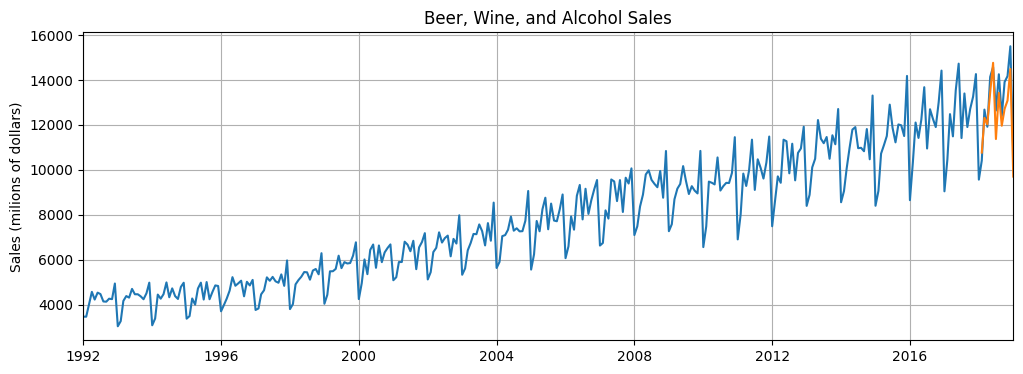

In [29]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (milions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_predictions)
plt.show()

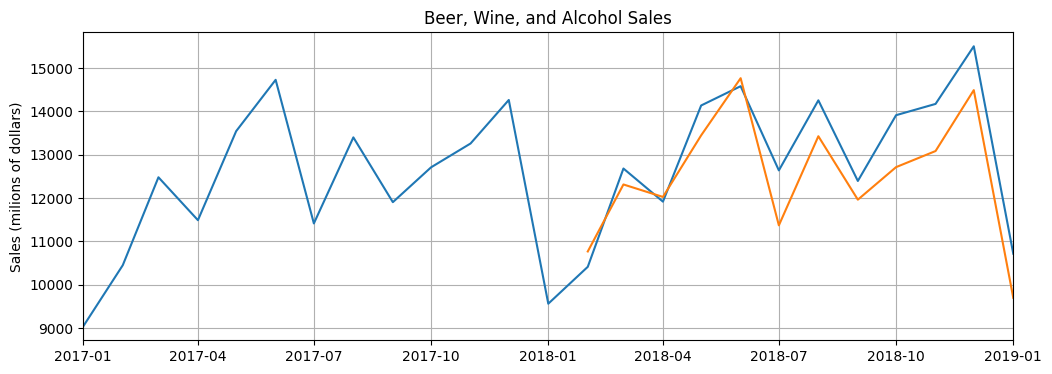

In [30]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (milions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

# Zoom in predictions
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x, true_predictions)
plt.show()

## Forcast predictions

In [31]:
torch.manual_seed(42)
epochs = 100

model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm, window_size)

for epoch in range(epochs):
  for seq, y_train in all_data:

    optimizer.zero_grad()
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                    torch.zeros(1,1,model.hidden_size))

    y_pred = model(seq)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch+1:2} | Loss: {loss.item():10.8f}")


Epoch:  1 | Loss: 0.02587314
Epoch:  2 | Loss: 0.09465445
Epoch:  3 | Loss: 0.01509333
Epoch:  4 | Loss: 0.02552922
Epoch:  5 | Loss: 0.02395275
Epoch:  6 | Loss: 0.02533163
Epoch:  7 | Loss: 0.01624598
Epoch:  8 | Loss: 0.00842217
Epoch:  9 | Loss: 0.00540895
Epoch: 10 | Loss: 0.02386868
Epoch: 11 | Loss: 0.01097274
Epoch: 12 | Loss: 0.02384703
Epoch: 13 | Loss: 0.02226047
Epoch: 14 | Loss: 0.00997709
Epoch: 15 | Loss: 0.00899566
Epoch: 16 | Loss: 0.01240691
Epoch: 17 | Loss: 0.01071532
Epoch: 18 | Loss: 0.01760209
Epoch: 19 | Loss: 0.02833267
Epoch: 20 | Loss: 0.00466252
Epoch: 21 | Loss: 0.01645298
Epoch: 22 | Loss: 0.02264179
Epoch: 23 | Loss: 0.00314858
Epoch: 24 | Loss: 0.00357288
Epoch: 25 | Loss: 0.00592912
Epoch: 26 | Loss: 0.01372536
Epoch: 27 | Loss: 0.00266469
Epoch: 28 | Loss: 0.00856959
Epoch: 29 | Loss: 0.00405919
Epoch: 30 | Loss: 0.00773709
Epoch: 31 | Loss: 0.01566765
Epoch: 32 | Loss: 0.00900770
Epoch: 33 | Loss: 0.00271724
Epoch: 34 | Loss: 0.00023318
Epoch: 35 | Lo

In [32]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()

for i in range(future):
  seq = torch.FloatTensor(preds[-window_size:])

  with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hidden_size),
                    torch.zeros(1,1,model.hidden_size))

    preds.append(model(seq).item())


In [33]:
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1,1))

In [34]:
true_predictions

array([[10415.00001808],
       [12683.00013363],
       [11919.00006013],
       [14137.99993426],
       [14583.00009555],
       [12640.00017402],
       [14257.00005591],
       [12395.9999277 ],
       [13913.99994579],
       [14173.99995232],
       [15504.        ],
       [10717.99998423],
       [11567.59098724],
       [13514.67876163],
       [13458.072575  ],
       [14606.80978471],
       [15098.33348089],
       [15084.19754666],
       [15852.22692645],
       [15249.09484765],
       [16795.97859251],
       [16579.97699726],
       [18658.27009118],
       [11869.45942441]])

In [35]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]')
x

array(['2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
       '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01'],
      dtype='datetime64[M]')

In [36]:
true_predictions[window_size:]

array([[11567.59098724],
       [13514.67876163],
       [13458.072575  ],
       [14606.80978471],
       [15098.33348089],
       [15084.19754666],
       [15852.22692645],
       [15249.09484765],
       [16795.97859251],
       [16579.97699726],
       [18658.27009118],
       [11869.45942441]])

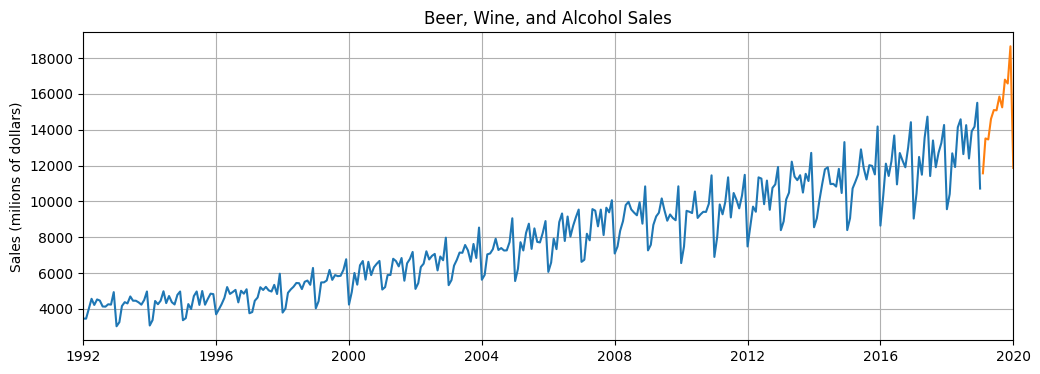

In [37]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (milions of dollars)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_predictions[window_size:])
plt.show()

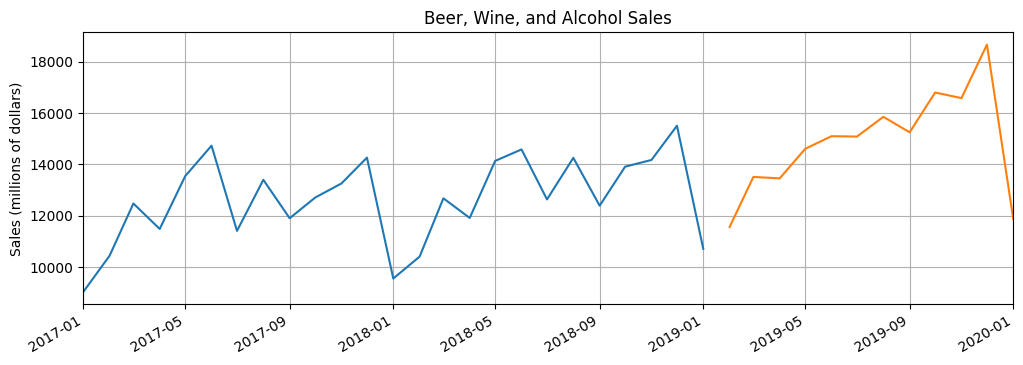

In [38]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()